In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import os

from keras.layers.core import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [5]:
# Setup
path = './data/hmdb51'
path_rowframes = './data/hmdb51/rawframes/'
path_annotations = './data/hmdb51/annotations/'

img_height = 224
img_width = 224
batch_size = 32
num_classes = 51

# Motion Stream Model Definition

In [12]:
checkpoint_filepath = './Models/motion_model_val_acc_best.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

In [37]:
num_classes = 51

model_mot= keras.models.Sequential()

# data_augmentation

model_mot.add(keras.layers.Conv2D(96, (7,7), strides = 2, input_shape=(224, 224, 20), activation = "relu"))
model_mot.add(keras.layers.BatchNormalization())
model_mot.add(keras.layers.MaxPooling2D((3,3), strides=2, padding="same"))

model_mot.add(keras.layers.ZeroPadding2D(padding = (1,1)))
model_mot.add(keras.layers.Conv2D(256, (5,5), strides = 2, activation='relu'))
model_mot.add(keras.layers.BatchNormalization())
model_mot.add(keras.layers.MaxPooling2D((3,3), strides=2, padding="same"))
          
model_mot.add(keras.layers.ZeroPadding2D(padding = (1,1)))
model_mot.add(keras.layers.Conv2D(512, (3,3), strides = 1, activation='relu'))

model_mot.add(keras.layers.ZeroPadding2D(padding = (1,1)))
model_mot.add(keras.layers.Conv2D(512, (3,3), strides = 1, activation='relu'))

model_mot.add(keras.layers.ZeroPadding2D(padding = (1,1)))
model_mot.add(keras.layers.Conv2D(512, (3,3), strides = 1, activation='relu'))
model_mot.add(keras.layers.MaxPooling2D((3,3), strides=2, padding="same"))

model_mot.add(keras.layers.Flatten())

model_mot.add(keras.layers.Dense(512, activation='relu'))
model_mot.add(keras.layers.Dropout(0.5))

model_mot.add(keras.layers.Dense(512, activation='relu'))
model_mot.add(keras.layers.Dropout(0.5))

model_mot.add(keras.layers.Dense(num_classes, activation="softmax"))

In [38]:
model_mot.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 109, 109, 96)      94176     
                                                                 
 batch_normalization_8 (Batc  (None, 109, 109, 96)     384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 55, 55, 96)       0         
 g2D)                                                            
                                                                 
 zero_padding2d_16 (ZeroPadd  (None, 57, 57, 96)       0         
 ing2D)                                                          
                                                                 
 conv2d_21 (Conv2D)          (None, 27, 27, 256)       614656    
                                                      

In [39]:
learning_rate = 1e-2
momentum = 0.9
optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)
# keras.optimizers.Adam(learning_rate=0.001)

model_mot.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                   metrics=['sparse_categorical_accuracy','sparse_top_k_categorical_accuracy'], 
                   optimizer=optimizer)

# Batch Generation Setting

In [49]:
# Setup
path = './data/hmdb51'
path_rowframes = './data/hmdb51/rawframes/'
path_annotations = './data/hmdb51/annotations/'

img_height = 224
img_width = 224
batch_size = 32
num_classes = 51

# Parametri del batch generator
num_of_snip=1
opt_flow_len=10
image_shape=(img_height, img_width)
epochs = 100

In [42]:
class DataSet():
    def __init__(self, 
                 num_of_snip=1, 
                 opt_flow_len=10, 
                 image_shape=(224, 224),
                 partition='train'):
        
    # opt_flow_len = (int) number of optical flow frames pet stacked optical flow (snip)

        self.opt_flow_len = opt_flow_len
        self.num_of_snip = num_of_snip
        self.image_shape = image_shape
        self.opt_flow_path = os.path.join(path_rowframes)
        self.path_annotations = path_annotations
        self.partition = partition
        
        # Get data
        self.video_list = self.find_videos_and_metadata()
        
    def find_videos_and_metadata(self):
        if self.partition == 'train':
            video_list = pd.read_csv(f'{self.path_annotations}/hmdb51_train_split_1_rawframes.txt', sep=" ", header=None) #train
            video_list.columns = ["path", "num_frames_tot", "class"]
        elif self.partition == 'val':
            video_list = pd.read_csv(f'{self.path_annotations}/hmdb51_val_split_1_rawframes.txt', sep=" ", header=None) #test
            video_list.columns = ["path", "num_frames_tot", "class"]
        else:
            raise Exception("invalid partition")
        return(video_list)
    
    def generator(self, batch_size):
        video_list = self.video_list
        idx = 0
        print(f"Creating {self.partition} with {len(self.video_list)} samples.")
        while 1:
            idx +=1
            #print(f"Generator creating batch {idx}")
            X, y = [], []
            for _ in range(batch_size):
                # Reset 
                stack = []

                # Get a random sample.
                row = video_list.sample(n=1).values.tolist()

                # Get the stacked optical flows from disk.
                stack = self.find_stacked_optical_flows(row)

                X.append(stack)
                y.append(row[0][2])

            X = np.array(X)
            y = np.array(y)
            y = np.squeeze(y)

            yield X, y
        
    def generator1(self, batch_size):
        video_list = self.video_list
        idx = 0
        print(f"Creating {self.partition} with {len(self.video_list)} samples.")
        idx +=1
        #print(f"Generattor creating batch {idx}")
        X, y = [], []
        for _ in range(batch_size):
            # Reset 
            stack = []

            # Get a random sample.
            row = video_list.sample(n=1).values.tolist()

            # Get the stacked optical flows from disk.
            stack = self.find_stacked_optical_flows(row)
            print(stack)
            X.append(stack)
            y.append(row[0][2])

        X = np.array(X)
        y = np.array(y)
        y = np.squeeze(y)

        return X, y
    
            
    def find_stacked_optical_flows(self, row):
        opt_flow_stack = []
        opt_flow_dir = self.opt_flow_path
        
        # Temporal parameters
        total_frames = row[0][1]
        win_len = (total_frames - self.opt_flow_len) // self.num_of_snip
        if self.partition=='train':
            start_frame = int(random.random() * win_len) + 1
        else:
            start_frame = int(0.5 * win_len) + 1
        frames = [] # selected optical flow frames
        for i in range(self.num_of_snip):
            frames += range(start_frame + self.opt_flow_len * i, 
                            start_frame + self.opt_flow_len * (i + 1))  
        if self.partition == 'train' and random.random() > 0.5:
            flip = True
        else:
            flip = False
        
        # Spatial Parameter
        img_test = cv2.imread(os.path.join(f'.\\{row[0][0]}' + '\\flow_x_' + str("%05d"%(1)) + '.jpg'), 0)
        top = int((img_test.shape[0] - self.image_shape[0]) * random.random())
        left = int((img_test.shape[1] - self.image_shape[1]) * random.random())
        right = left + self.image_shape[1]
        bottom = top + self.image_shape[0]
        
        # loop over frames
        for i_frame in frames:
            # x flow
            img = None # reset to be safe
            temp_path = None
            temp_path = row[0][0]
            img = cv2.imread(os.path.join(f'.\\{temp_path}' + '\\flow_x_' + str("%05d"%(i_frame)) + '.jpg'), 0)
            #print(os.path.join(f'.\\{temp_path}' + '\\flow_x_' + str("%05d"%(i_frame)) + '.jpg'))
            #print(img.shape)
            img = np.array(img)
            # mean substraction 
            img = img - np.mean(img)
            if self.partition == 'train':
                # random crop
                img = img[top : bottom, left : right]
            else:
                #resize
                img = cv2.resize(img, self.image_shape)
            img = img / 255. # normalize pixels 
            if flip:
                img = -img
            img = cv2.resize(img, self.image_shape)
            #print(img.shape)
            opt_flow_stack.append(img)
            
            # y flow
            img2 = None # reset to be safe
            img2 = cv2.imread(os.path.join(f'.\\{temp_path}' + '\\flow_y_' + str("%05d"%(i_frame)) + '.jpg'), 0)
            #print(img2.shape)
            img2 = np.array(img2)
            #img2 = np.swapaxes(img2, 0, 1)
            img2 = img2 - np.mean(img2)
            if self.partition == 'train':
                 #random crop
                img2 = img2[top : bottom, left : right]
            else:
                #resize
                img2= cv2.resize(img2, self.image_shape)
            img2 = img2 / 255. # normalize pixels 
            if flip:
                img2 = -img2
            img2 = cv2.resize(img2, self.image_shape)
            #print(img2.shape)
            opt_flow_stack.append(img2)
            
        opt_flow_stack = np.array(opt_flow_stack)
        opt_flow_stack = np.swapaxes(opt_flow_stack, 0, 1)
        opt_flow_stack = np.swapaxes(opt_flow_stack, 1, 2)
        # random horizontal flip for training sets
        if flip:
            opt_flow_stack = np.flip(opt_flow_stack, 0)
        return opt_flow_stack
            
        

# Model Fit

Test

In [43]:
videos_train = DataSet(num_of_snip=num_of_snip, opt_flow_len=opt_flow_len, partition='train')
videos_val = DataSet(num_of_snip=num_of_snip, opt_flow_len=opt_flow_len, partition='val')

In [44]:
X, y = videos_train.generator1(32)
X.shape

Creating train with 3570 samples.
[[[-1.19882047e-02 -1.31280637e-04  1.96078431e-05 ... -1.29055862e-02
   -0.00000000e+00  1.63398693e-05]
  [-1.19882047e-02 -1.31280637e-04  1.96078431e-05 ... -1.29055862e-02
   -0.00000000e+00  1.63398693e-05]
  [-1.59097733e-02 -1.31280637e-04  1.96078431e-05 ... -1.29055862e-02
   -0.00000000e+00  1.63398693e-05]
  ...
  [ 1.15412071e-02 -1.31280637e-04  1.96078431e-05 ...  1.06238256e-02
   -0.00000000e+00  1.63398693e-05]
  [ 1.15412071e-02 -1.31280637e-04  1.96078431e-05 ...  1.06238256e-02
   -0.00000000e+00  1.63398693e-05]
  [ 1.15412071e-02 -1.31280637e-04  1.96078431e-05 ...  1.06238256e-02
   -0.00000000e+00  1.63398693e-05]]

 [[-1.59097733e-02 -1.31280637e-04  1.96078431e-05 ... -8.98401757e-03
   -0.00000000e+00  1.63398693e-05]
  [-1.59097733e-02 -1.31280637e-04  1.96078431e-05 ... -8.98401757e-03
   -0.00000000e+00  1.63398693e-05]
  [-1.59097733e-02 -1.31280637e-04  1.96078431e-05 ... -8.98401757e-03
   -0.00000000e+00  1.63398693e

(32, 224, 224, 20)

Fit

In [45]:
# batch size 
step_per_epoch_train = len(videos_train.video_list) // batch_size
print(step_per_epoch_train)
step_per_epoch_val = len(videos_val.video_list) // batch_size
print(step_per_epoch_val)

111
47


In [46]:
train_generator = videos_train.generator(batch_size)

val_generator = videos_val.generator(batch_size)

In [48]:
# %tb
history_cnn_spatial_stream = model_mot.fit_generator(generator =train_generator, 
                                            steps_per_epoch=step_per_epoch_train, 
                                            validation_data=val_generator,
                                            validation_steps=step_per_epoch_val, 
                                            epochs=5,
                                            callbacks=[model_checkpoint_callback])
                

c:\Users\giorg\Documents\venv\deepL37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/5
111/111 [==============================] - 275s 2s/step - loss: 3.9408 - sparse_categorical_accuracy: 0.0197 - sparse_top_k_categorical_accuracy: 0.0974 - val_loss: 3.9336 - val_sparse_categorical_accuracy: 0.0193 - val_sparse_top_k_categorical_accuracy: 0.0951
Epoch 2/5
111/111 [==============================] - ETA: 0s - loss: 3.9323 - sparse_categorical_accuracy: 0.0231 - sparse_top_k_categorical_accuracy: 0.1118

KeyboardInterrupt: 

In [29]:
score = model_mot.evaluate_generator(val_generator, verbose=1, steps=step_per_epoch_val)
#print('sparse_categorical_accuracy:', score[0])
#print('sparse_top_k_categorical_accuracy:', score[1])

c:\Users\giorg\Documents\venv\deepL37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


47/47 [==============================] - 55s 1s/step - loss: 3.3076 - sparse_categorical_accuracy: 0.2121 - sparse_top_k_categorical_accuracy: 0.4980


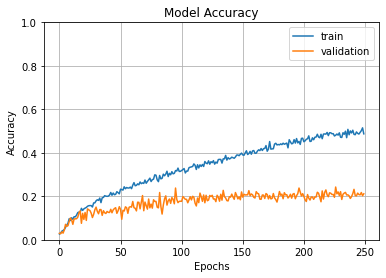

In [28]:
fig1 = plt.gcf()
plt.plot(history_cnn_spatial_stream.history['sparse_categorical_accuracy'])
plt.plot(history_cnn_spatial_stream.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
metric_plot = 'Accuracy'
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig(f'./Report/Plots/motion_stream/motion_stream_V1_epoch{epochs}_batch{batch_size}_optSDG_{learning_rate}_{momentum}_metric{metric_plot}.png')
plt.show()

In [32]:
model_mot.save(f'./Models/motion_stream/motion_stream_V1_epoch{epochs}_batch{batch_size}_optSDG_lr{learning_rate}_momentum{momentum}.h5')
# model_mot.save_weights('./Models/model_mot_weights.h5')